In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../src/silica_opt_insilico/')
from silica_opt_insilico import experiment, execute, data_processing, post_process, contour_animated
from saxs_data_processing import target_comparison
    
import numpy as np
import matplotlib.pyplot as plt

import pickle
import matplotlib.animation as animation
from IPython.display import HTML
import os

from apdist.torch import AmplitudePhaseDistance as torch_apdist
from apdist.torch import plot_warping as plot_warping_torch

from apdist.distances import AmplitudePhaseDistance as dist
import torch 

## In silico optimization simulation

- objective functions work on volume fractions
- BO works on bounds/0-1


Ground truth:

- Diameter 80nm at [0.007, 0.018, 0.04]
- PDI min at [0.007, 0.025, 0.03]

## Parameters 

### SAXS Data processing parameters

### Experiment 'execution' parameters

In [2]:
# physical experiment bounds

teos_min_vf = 0.005
ammonia_min_vf = 0.005
water_min_vf = 0.005

teos_max_vf = 0.1
ammonia_max_vf = 0.1
water_max_vf = 0.15

noise_frac = 0.5 # what fraction of experimental noise to use

target_r_nm = 40 # particle size target

budget = 100

### Campaign structure 

### 2. Calculate scattering

In [3]:
# q range to consider up to and including spline fit step
q_min_subtract = 0.002
q_max_subtract = 0.035

# q range to interpolate spline fit on and perform distance metric calculation with
q_min_spl = 0.003
q_max_spl = 0.03
n_interpolate_gridpts = 1001 # number of grid points to interpolate q on.

In [4]:

target_r_angs = target_r_nm*10
target_pdi = 0.1
sld_silica = 8.575
sld_etoh = 9.611

In [5]:
q_grid = np.linspace(np.log10(q_min_spl), np.log10(q_max_spl), n_interpolate_gridpts)

q_grid_nonlog = 10**q_grid
target_I = target_comparison.target_intensities(q_grid_nonlog, target_r_angs, target_pdi, sld_silica, sld_etoh)
target_I = np.log10(target_I)

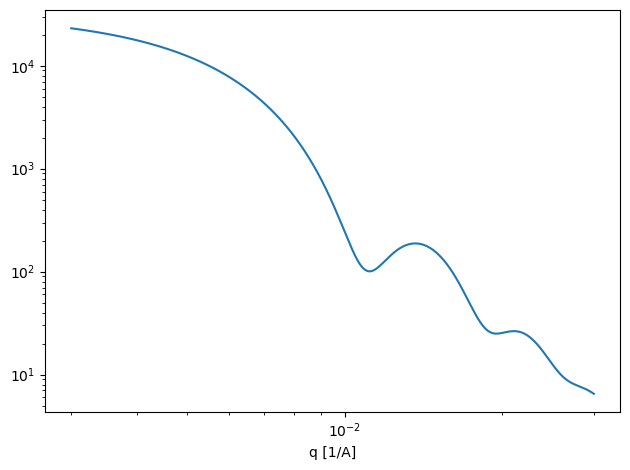

In [6]:
fig, ax = plt.subplots()
ax.loglog(10**q_grid, 10**target_I)
ax.set_xlabel('q [1/A]')

plt.tight_layout()


In [110]:
trials = {'baseline':{
            'batch_size':5,
            'amplitude_weight':0.1,
            'm_samples':5,
            'lower_bounds':[0.005, 0.005, 0.005], 
            'upper_bounds':[0.1, 0.1, 0.15], 
            'noise_level':0.05,
            'characterization':'SAXS',
            'distance':'apdist_torch'
        },
            'noise1':{
            'batch_size':5,
            'amplitude_weight':0.1,
            'm_samples':5,
            'lower_bounds':[0.005, 0.005, 0.005], 
            'upper_bounds':[0.1, 0.1, 0.15], 
            'noise_level':1,
            'characterization':'SAXS',
            'distance':'apdist_torch'
        },
          
    }

In [7]:
trials_noise = {'noise1':{
            'batch_size':5,
            'amplitude_weight':0.1,
            'm_samples':5,
            'lower_bounds':[0.005, 0.005, 0.005], 
            'upper_bounds':[0.1, 0.1, 0.15], 
            'noise_level':1,
            'characterization':'SAXS',
            'distance':'apdist_torch'
        },
    }

## Update random with new distances and process

In [72]:
for i in range(3):
    with open(f'SobolBaseline_replicate_{i}.pkl', 'rb') as f:
        sobol_og = pickle.load(f)
    with open(f'recalculate_sobolbaseline{i}.pkl', 'rb') as f:
        sobol_recalc = pickle.load(f)
    
    sobol_recalc = {entry['uuid']:entry for entry in sobol_recalc}
    
    
    for uid in sobol_og.keys():
        #print(uid)
        #print(sobol_og[uid]['ap_distance_reporting'])
        #print(sobol_recalc[uid]['ap_report'])
        if uid == '1e69758d-2f91-4394-ab3e-ebca72a9e38a':
            print(i, 'updating uid')
            sobol_og[uid]['ap_distance_reporting'] = 0.1164 # this number comes from recalculation run below in this notebook. 
        sobol_og[uid]['ap_distance_reporting'] = sobol_recalc[uid]['ap_report']
    
    with open(f'SobolBaseline_recalc_replicate_{i}.pkl', 'wb') as f:
        pickle.dump(sobol_og, f)
    

2 updating uid


### 1. Find true minima for this objective function (do once per objective)

In [38]:
true_min = [6.936e-03, 2.021e-02, 4.000e-02] # for original 80nm objective

########################
Results for baseline
Iterations to convergence (threshold 0.05): [70, 40, 45], mean: 51.666666666666664
Closest composition distances observed: [0.036725864, 0.03510577, 0.064941525]
<function plot_phasemap.<locals>.<lambda> at 0x7ecccde53740>
<function plot_phasemap.<locals>.<lambda> at 0x7eccc767a8e0>
<function plot_phasemap.<locals>.<lambda> at 0x7eccc1d46480>
<function plot_phasemap.<locals>.<lambda> at 0x7eccbd1b23e0>
<function plot_phasemap.<locals>.<lambda> at 0x7eccbbc1a340>
<function plot_phasemap.<locals>.<lambda> at 0x7eccf1581580>
########################
Results for noise1
Iterations to convergence (threshold 0.05): [47, 'Not converged', 128], mean: 102.33333333333333
Closest composition distances observed: [0.037689984, 0.09997512, 0.035720766]
<function plot_phasemap.<locals>.<lambda> at 0x7eccc2260ae0>
<function plot_phasemap.<locals>.<lambda> at 0x7eccc4413c40>
<function plot_phasemap.<locals>.<lambda> at 0x7eccde862c00>
<function plot_phasemap

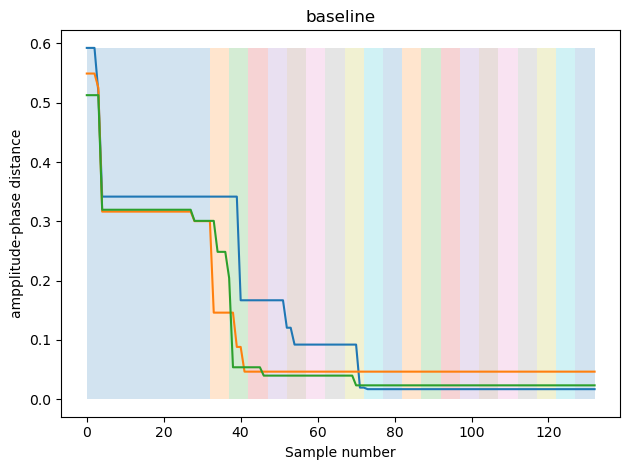

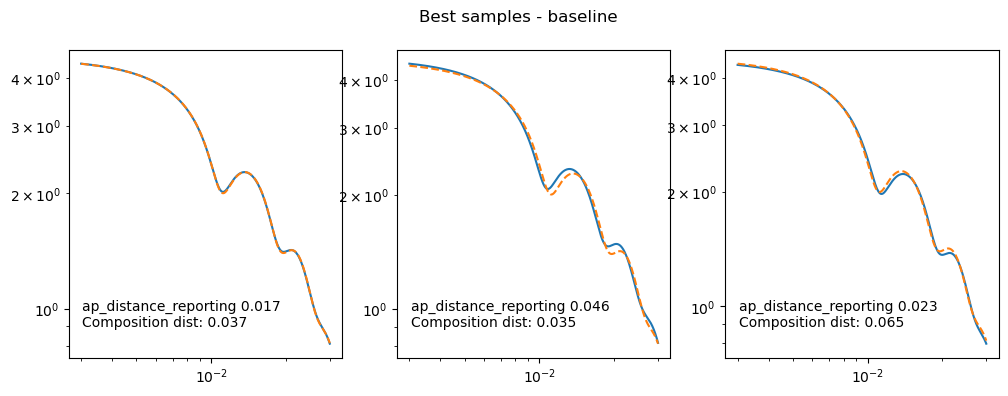

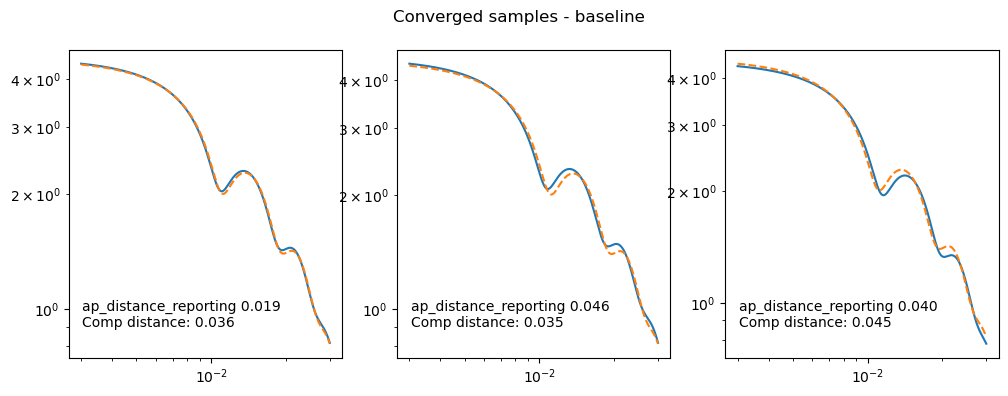

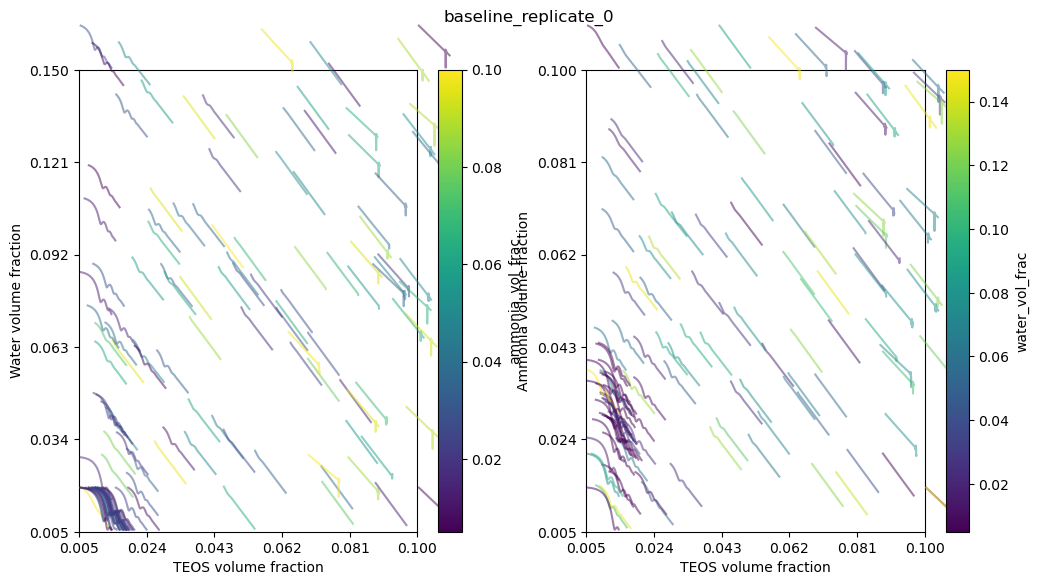

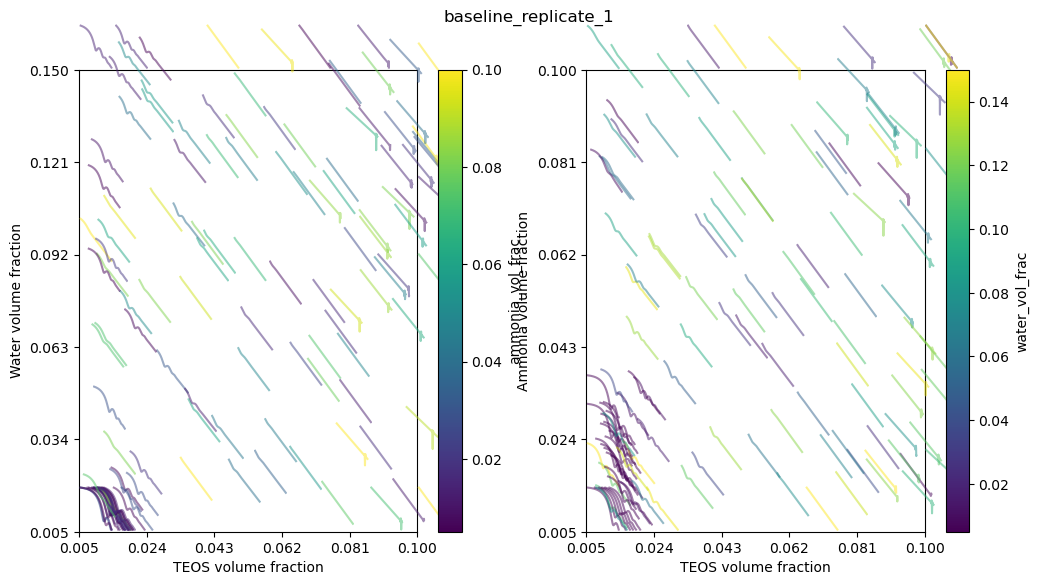

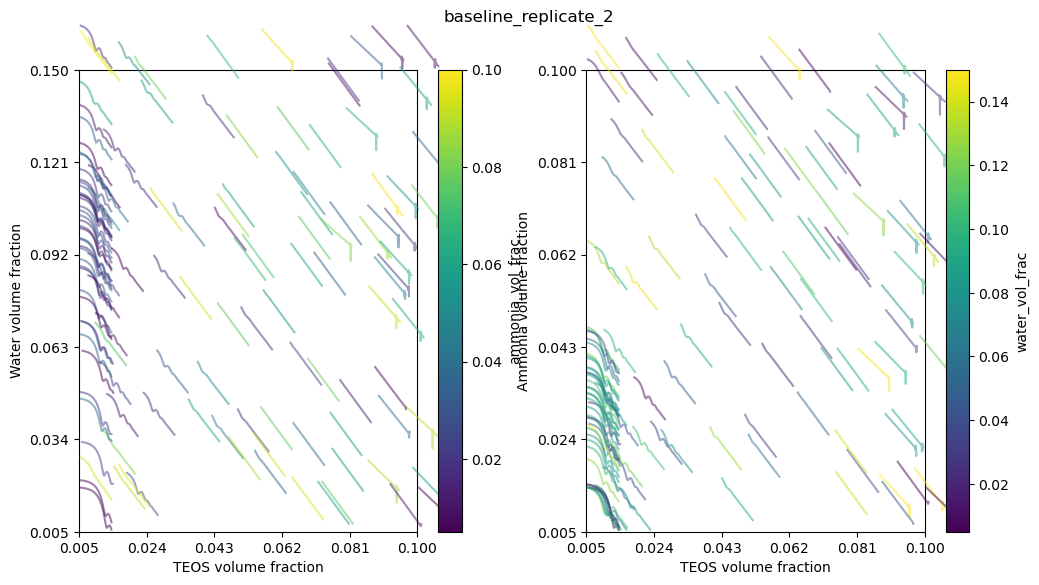

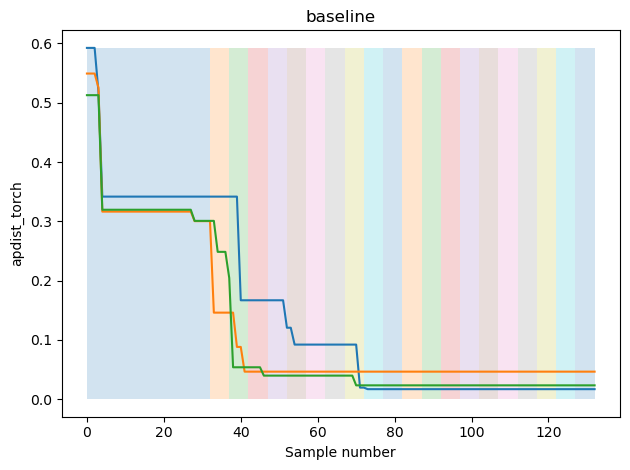

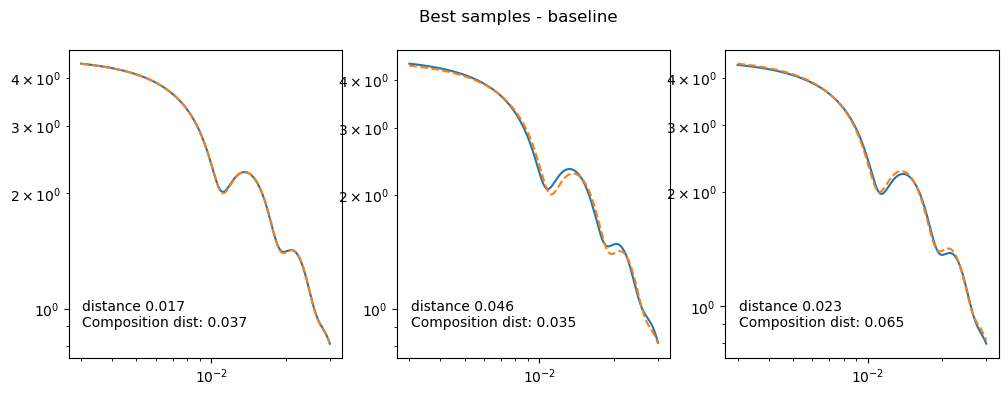

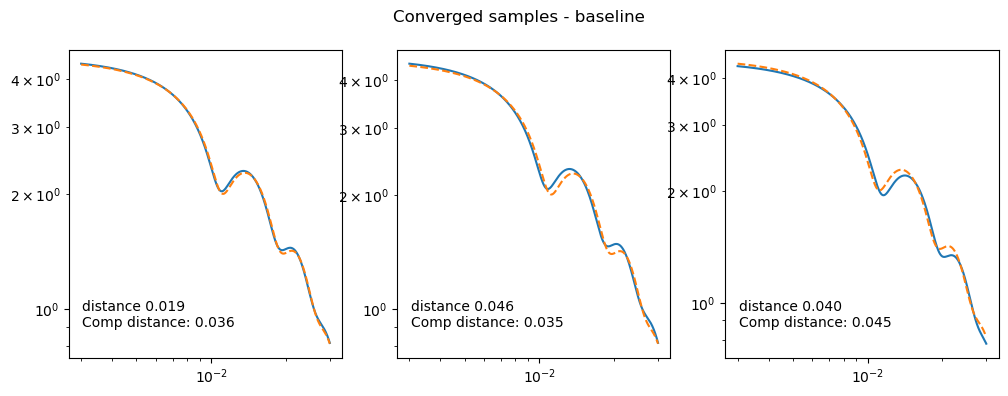

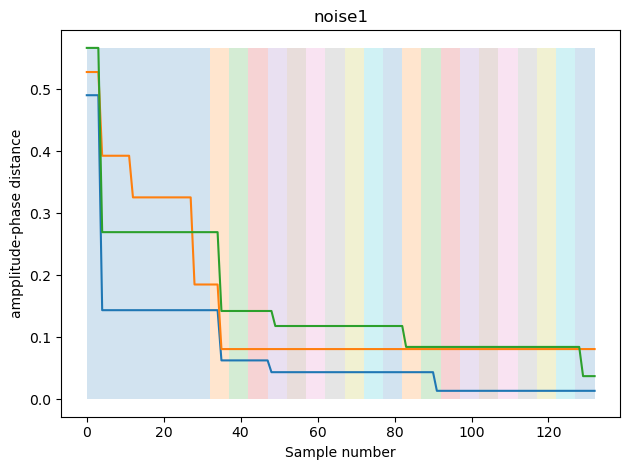

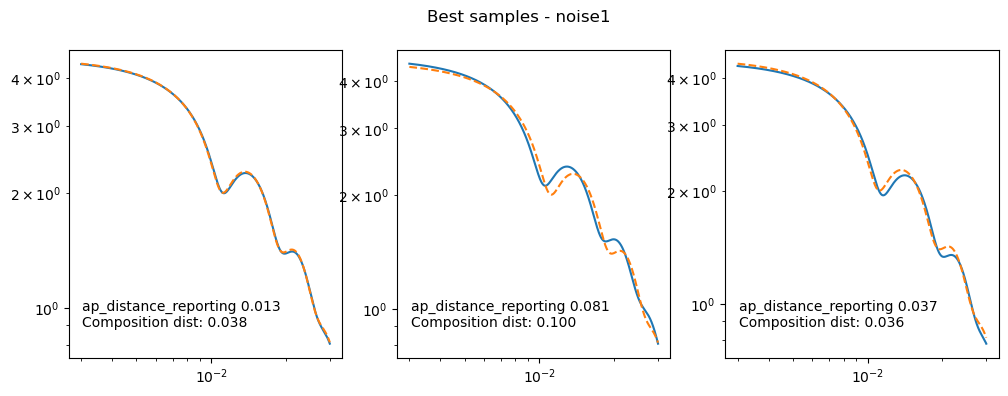

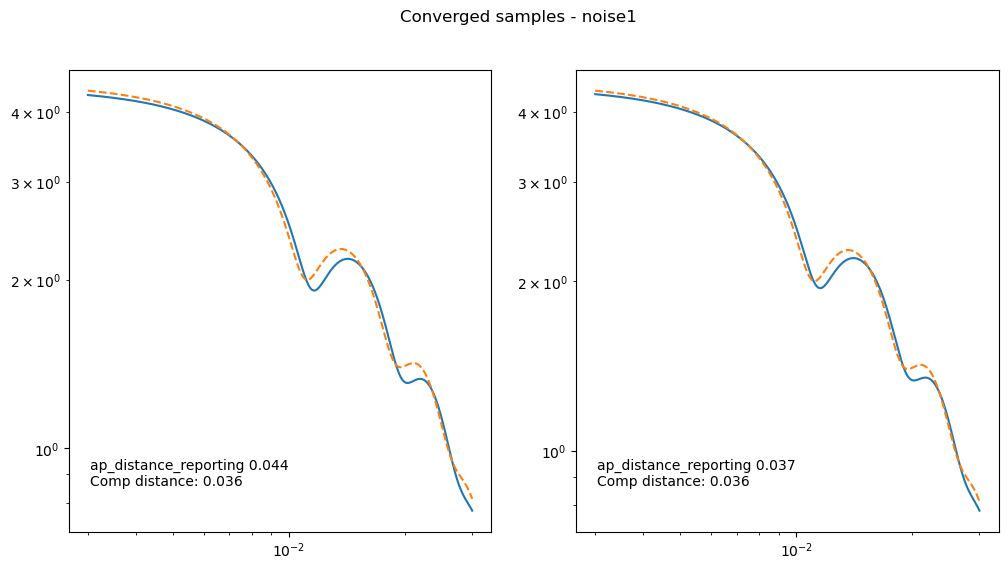

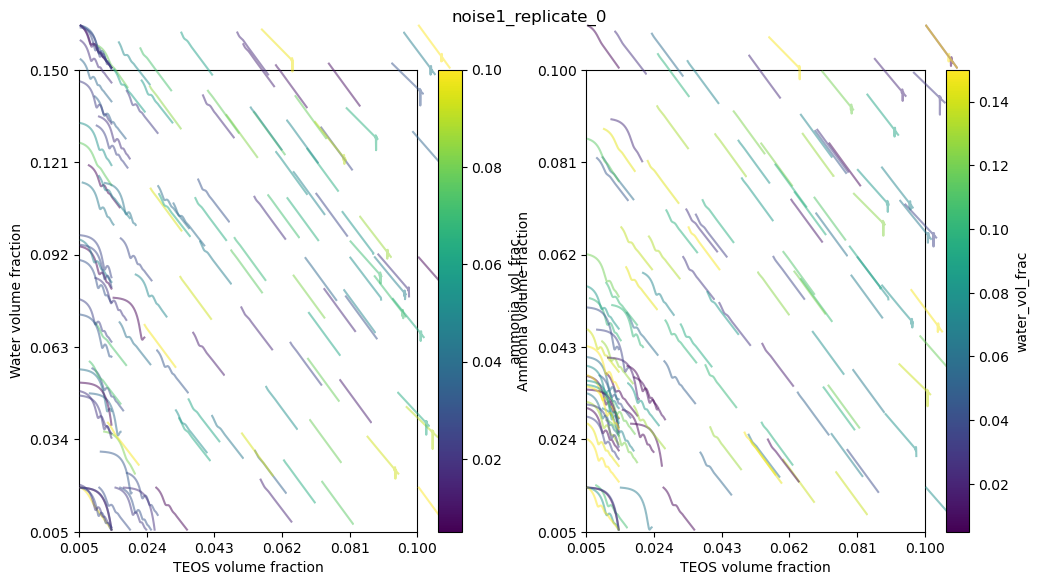

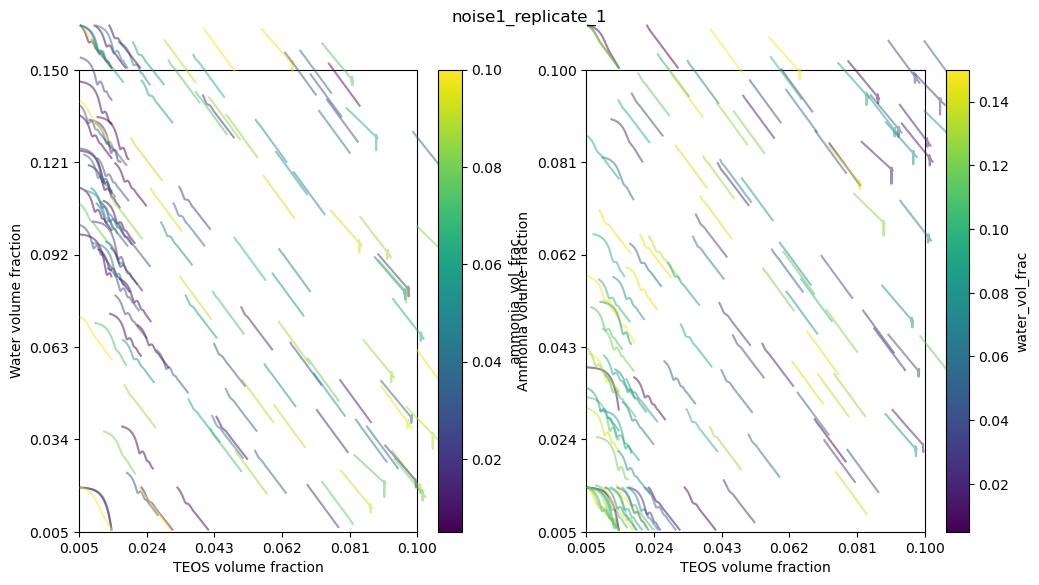

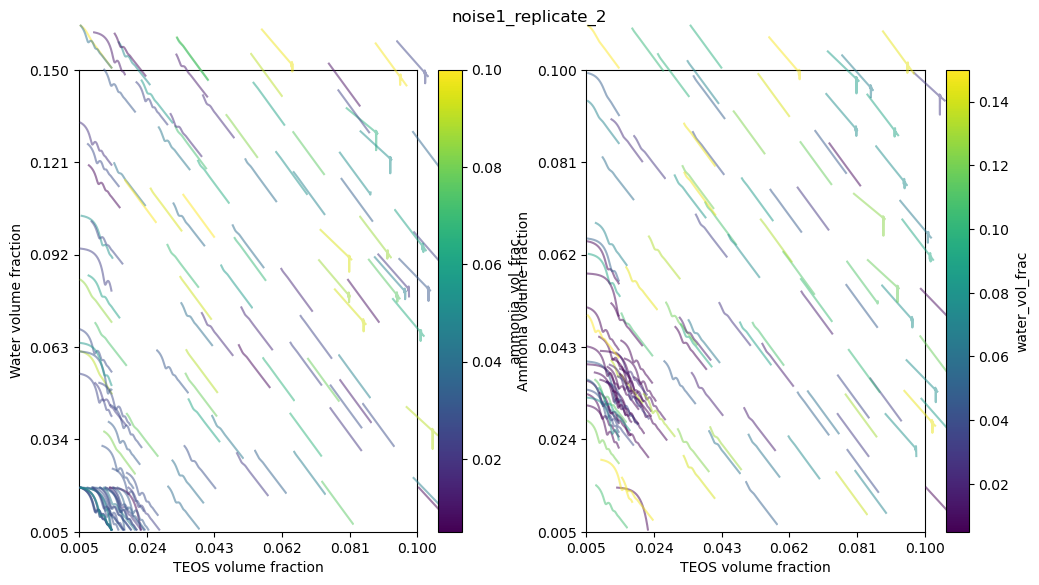

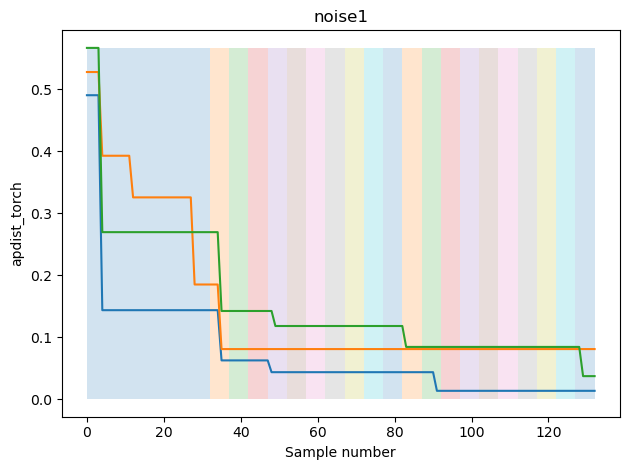

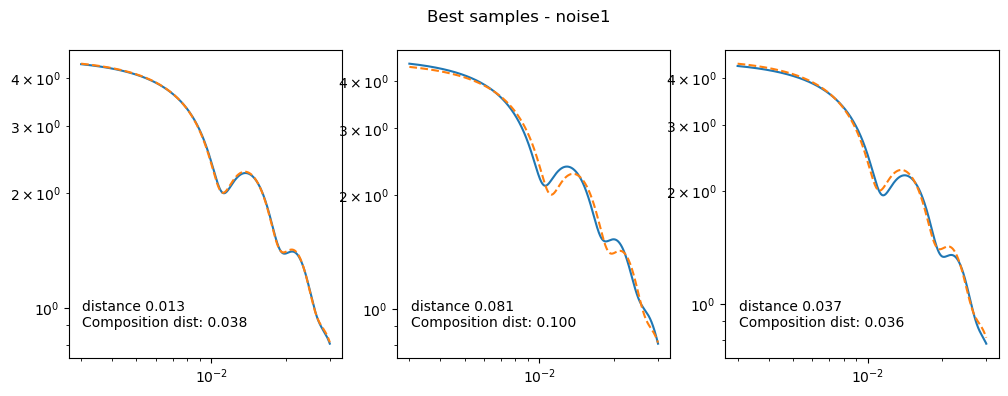

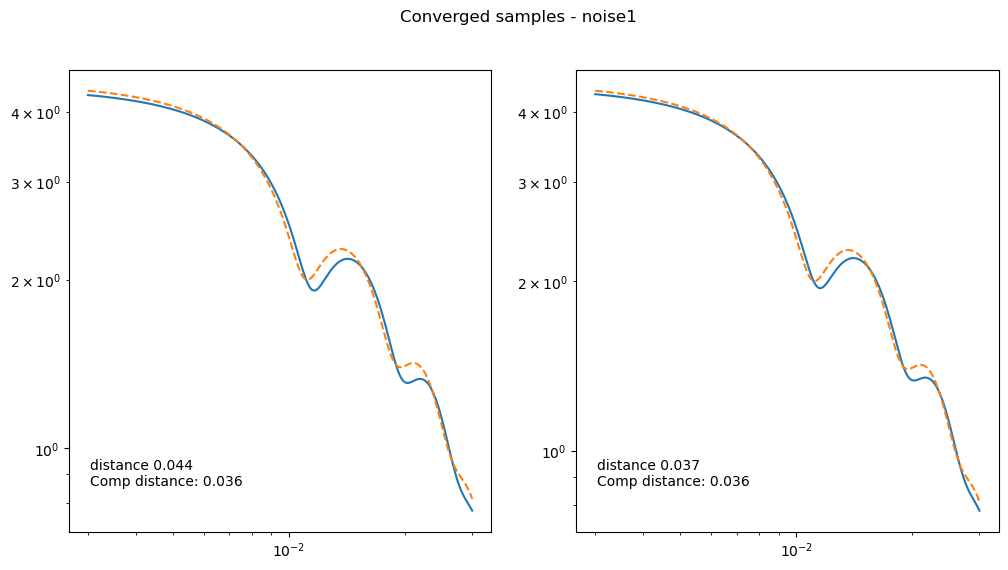

In [143]:
convergence_threshold = 0.05
n_replicates = 3
budget = 40

#contour plot things
n_grid = 50
with open('../TEOS_water_ammoniaOptima_gridvals_80nm_ogfuncs_50.npy', 'rb') as f:
    Z_ammonia = np.load(f)

with open('../TEOS_ammonia_waterOptima_gridvals_80nm_ogfuncs_50.npy', 'rb') as f:
    Z_water = np.load(f)

best_distances_results = {}
best_uuid_results = {}

for trial_name, params in trials.items():


    if trial_name == 'DLS':
        params['distance'] = 'DLS'

    batch_size = params['batch_size']
    m_samples = params['m_samples']

    if batch_size == 0:
        n_batches = 0
    else:
        n_batches = int(np.ceil(budget/batch_size))

        
    os.mkdir(trial_name)
    data_complete, data_batches, best_distances_list, best_uuids_list, converge_iterations, converge_uuid, best_composition_dist, name_bounds = post_process.process_distances(trial_name, params, true_min, n_replicates = n_replicates, convergence_threshold = convergence_threshold)
    fig = post_process.convergence_plot(data_complete, best_distances_list, best_uuids_list, name_bounds, trial_name)
    plt.savefig(f'{trial_name}/convergence_plot_{trial_name}.png', dpi = 300)
    best_scat = post_process.best_scatterer_plots(data_complete, best_uuids_list, q_grid_nonlog, target_I, trial_name, true_min)
    plt.savefig(f'{trial_name}/best_scatterer_plot_{trial_name}.png', dpi = 300)
    converge_scat = post_process.converge_scatterer_plots(data_complete, converge_uuid, q_grid_nonlog, target_I, trial_name, true_min)
    plt.savefig(f'{trial_name}/converged_scatterer_plots_{trial_name}.png', dpi = 300)

    best_distances_results[trial_name] = best_distances_list
    best_uuid_results[trial_name] = best_uuids_list
    nanconverged = []
    for el in converge_iterations:
        if el == 'Not converged':
            el = 132
        nanconverged.append(el)
    mean_converge = np.nanmean(nanconverged) 

    print('########################')
    print(f'Results for {trial_name}')
    print(f'Iterations to convergence (threshold {convergence_threshold}): {converge_iterations}, mean: {mean_converge}')
    print(f'Closest composition distances observed: {best_composition_dist}')

    lower_bounds = params['lower_bounds']
    upper_bounds = params['upper_bounds']
    
    ammonia = np.linspace(lower_bounds[1], upper_bounds[1], n_grid)
    water = np.linspace(lower_bounds[2], upper_bounds[2], n_grid)
    teos = np.linspace(lower_bounds[0], upper_bounds[0], n_grid)
    for i in range(n_replicates):
        phased = post_process.phase_diagram(data_batches[i], params['lower_bounds'], params['upper_bounds'], q_grid, f'{trial_name}_replicate_{i}')
        plt.savefig(f'{trial_name}/{trial_name}_replicate_{i}.png', dpi = 300)#

        #anim = contour_animated.ContourAnimation(ammonia, water, teos, Z_ammonia, Z_water, 
        #                        data_batches[i], best_uuids_list[i], n_batches, true_min, trial_name, n_grid, m_samples, batch_size)
        
        #anim.save(f"{trial_name}/{trial_name}_replicate_{i}.html", format="html")  # Saves as an HTML file

    # consider convergence on optimizaiton metric used
    data_complete, data_batches, best_distances_list_optim, best_uuids_list_optim, converge_iterations_optim, converge_uuid_optim, best_composition_dist_optim, name_bounds = post_process.process_distances(trial_name, params, true_min, dist_name = 'distance', n_replicates = n_replicates, convergence_threshold = convergence_threshold)
    fig = post_process.convergence_plot(data_complete, best_distances_list_optim, best_uuids_list_optim, name_bounds, trial_name, ylabel = params['distance'])
    plt.savefig(f'{trial_name}/convergence_plot_optimdistance_{trial_name}.png', dpi = 300)
    best_scat = post_process.best_scatterer_plots(data_complete, best_uuids_list_optim, q_grid_nonlog, target_I, trial_name, true_min, distance = 'distance')
    plt.savefig(f'{trial_name}/best_scatterer_plot_optimdistance_{trial_name}.png', dpi = 300)
    converge_scat = post_process.converge_scatterer_plots(data_complete, converge_uuid_optim, q_grid_nonlog, target_I, trial_name, true_min, distance = 'distance')
    plt.savefig(f'{trial_name}/converged_scatterer_plots_optimdistance_{trial_name}.png', dpi = 300)


    

In [50]:
with open('SobolBaseline_replicate_2.pkl', 'rb') as f:
    sobol_rep2 = pickle.load(f)
    

In [82]:
N_SAMPLES = q_grid.shape[0]

optim_kwargs = {"n_iters":400, 
                "n_basis":15, 
                "n_layers":15,
                "domain_type":"linear",
                "basis_type":"palais",
                "n_restarts":50,
                "lr":1e-1,
                "n_domain":N_SAMPLES
                }

q_grid_scaled = (q_grid - min(q_grid))/(max(q_grid) - min(q_grid))

In [70]:
best_uuids_list[2][-1]

'1e69758d-2f91-4394-ab3e-ebca72a9e38a'

In [90]:
sobol_best = sobol_rep2['b87345f9-03d0-4897-a50c-460626ed1ec6']['I_scaled']

In [60]:
amplitude, phase, output = torch_apdist(torch.from_numpy(q_grid_scaled), 
                                        torch.from_numpy(target_I), 
                                        torch.from_numpy(sobol_best), 
                                        **optim_kwargs
                                        )

In [65]:
fixed_sobol_2_best_dist = 0.1*amplitude + 0.9*phase

In [66]:
fixed_sobol_2_best_dist

tensor(0.1164, dtype=torch.float64)

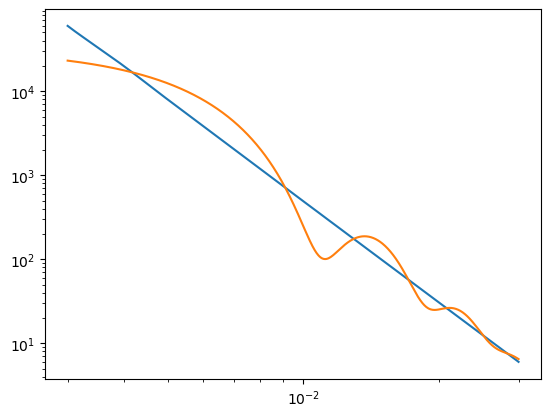

In [91]:
plt.loglog(10**q_grid, 10**sobol_best)
plt.loglog(10**q_grid, 10**target_I)

## Re-process sobol distances for best samples

In [79]:
with open('SobolBaseline_recalc_replicate_2.pkl', 'rb') as f:
    soboldata = pickle.load(f)

In [100]:
overall_results = []
for i in range(3):
    print('starting replicate ', i)
    print(overall_results)

    with open(f'SobolBaseline_recalc_replicate_{i}.pkl', 'rb') as f:
        soboldata = pickle.load(f)
    best_samples = []
    best_uuids = []
    best_apdist = None
    
    new_results = {}
    for uuid_val, entry in soboldata.items():
        if best_apdist is None:
            best_apdist = entry['ap_distance_reporting']
            best_samples.append(entry)
            best_uuids.append(uuid_val)
        else:
            if entry['ap_distance_reporting'] < best_apdist:
                best_apdist = entry['ap_distance_reporting']
                best_samples.append(entry)
                best_uuids.append(uuid_val)
    
    for uid in best_uuids:
        print('starting ', uid)
        results = {}
        scattering = soboldata[uid]['I_scaled']
        amplitude, phase, output = torch_apdist(torch.from_numpy(q_grid_scaled), # all the inputs should be torch.Tensor
                                            torch.from_numpy(target_I), 
                                            torch.from_numpy(scattering), 
                                            **torch_optim_kwargs
                                            )
        ap_dist_report = 0.1*amplitude + 0.9*phase
        print('ap report: ', ap_dist_report)
        print('amplitude phase: ', amplitude, phase)
        results['amplitude'] = amplitude
        results['phase'] = phase
        results['ap_report'] = ap_dist_report
        new_results[uid] = results

    overall_results.append(new_results)

starting replicate  0
[]
starting  ea8d5054-8e19-4239-be48-1b2584270829
ap report:  tensor(0.5285, dtype=torch.float64)
amplitude phase:  tensor(0.6594, dtype=torch.float64) tensor(0.5140)
starting  4cd015aa-da53-451d-96e4-26580d24da63
ap report:  tensor(0.3972, dtype=torch.float64)
amplitude phase:  tensor(0.4783, dtype=torch.float64) tensor(0.3882)
starting  216acf6f-94f0-40a0-a942-6ee1f576dbeb
ap report:  tensor(0.3216, dtype=torch.float64)
amplitude phase:  tensor(0.3844, dtype=torch.float64) tensor(0.3146)
starting  a66e8fa8-c0a7-49bb-812a-748fbcdc35da
ap report:  tensor(0.1078, dtype=torch.float64)
amplitude phase:  tensor(0.2709, dtype=torch.float64) tensor(0.0896)
starting replicate  1
[{'ea8d5054-8e19-4239-be48-1b2584270829': {'amplitude': tensor(0.6594, dtype=torch.float64), 'phase': tensor(0.5140), 'ap_report': tensor(0.5285, dtype=torch.float64)}, '4cd015aa-da53-451d-96e4-26580d24da63': {'amplitude': tensor(0.4783, dtype=torch.float64), 'phase': tensor(0.3882), 'ap_report':

In [103]:
with open('Updated_sobol_best_distances.pkl', 'wb') as f:
    pickle.dump(overall_results, f)

In [104]:
overall_results

[{'ea8d5054-8e19-4239-be48-1b2584270829': {'amplitude': tensor(0.6594, dtype=torch.float64),
   'phase': tensor(0.5140),
   'ap_report': tensor(0.5285, dtype=torch.float64)},
  '4cd015aa-da53-451d-96e4-26580d24da63': {'amplitude': tensor(0.4783, dtype=torch.float64),
   'phase': tensor(0.3882),
   'ap_report': tensor(0.3972, dtype=torch.float64)},
  '216acf6f-94f0-40a0-a942-6ee1f576dbeb': {'amplitude': tensor(0.3844, dtype=torch.float64),
   'phase': tensor(0.3146),
   'ap_report': tensor(0.3216, dtype=torch.float64)},
  'a66e8fa8-c0a7-49bb-812a-748fbcdc35da': {'amplitude': tensor(0.2709, dtype=torch.float64),
   'phase': tensor(0.0896),
   'ap_report': tensor(0.1078, dtype=torch.float64)}},
 {'980ef689-395e-4218-a5db-9f48e3ed576e': {'amplitude': tensor(0.6594, dtype=torch.float64),
   'phase': tensor(0.5139),
   'ap_report': tensor(0.5285, dtype=torch.float64)},
  'b97a0e8e-f1f2-41f5-9292-332b7ce2a4f1': {'amplitude': tensor(0.4824, dtype=torch.float64),
   'phase': tensor(0.3894),
   

## Sobol convergence plot

In [105]:
best_distances = []
current_best = None
for i in range(3):
    best_dist_rep = []
    with open(f'SobolBaseline_replicate_{i}.pkl', 'rb') as f:
        soboldata = pickle.load(f)

    for uid in soboldata.keys():
        if uid in overall_results[i].keys():
            current_best = overall_results[i][uid]['ap_report']

        best_dist_rep.append(current_best)

    best_distances.append(best_dist_rep)

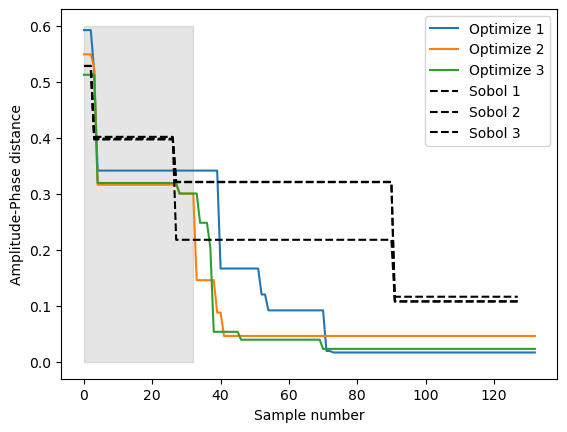

In [126]:
fig, ax = plt.subplots()

baseline_results = best_distances_results['baseline']
for i in range(3):
    ax.plot(baseline_results[i], label = f'Optimize {i+1}')
for i in range(3):
    ax.plot(best_distances[i], ls = '--', color = 'k', label = f'Sobol {i+1}')



ax.legend()
ax.fill_between((0, 32), 0, 0.6, color = 'k', alpha = 0.1)
ax.set_xlabel('Sample number')
ax.set_ylabel('Amplitude-Phase distance')
plt.savefig('newcampaign_optvsrandom.png', dpi = 300)


## Plot sobol rep 1 best scatterer

In [128]:
sobol_rep1_best = list(overall_results[0].keys())[-1]

In [129]:
with open(f'SobolBaseline_replicate_0.pkl', 'rb') as f:
    soboldata = pickle.load(f)
I_sobolrep1 = soboldata[sobol_rep1_best]['I_scaled']

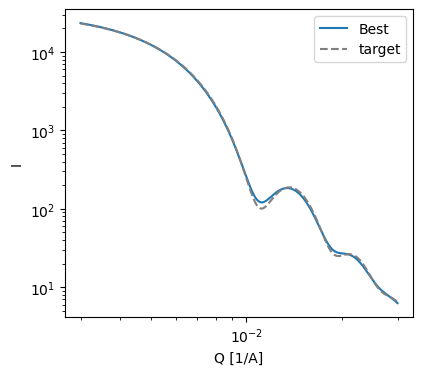

In [139]:
fig, ax = plt.subplots(figsize = (4.5, 4))
ax.loglog(10**q_grid, 10**I_sobolrep1, label = 'Best')
ax.loglog(10**q_grid, 10**target_I, ls = '--', color = 'gray', label = 'target')
ax.set_xlabel('Q [1/A]')
ax.set_ylabel('I')
ax.legend()
plt.savefig('Newcampaign_sobolrep0best.png', dpi = 300)

## Plot optim rep 1 best

In [141]:
with open('baseline_replicate_0.pkl', 'rb') as f:
    optimrep0 = pickle.load(f) 

In [148]:
optim_uid = best_uuid_results['baseline'][0][-1]

In [149]:
optim_uid

'10dbafee-5399-47d6-8f56-b24dfd935f0c'

In [150]:
I_optim0 = optimrep0[optim_uid]['I_scaled']

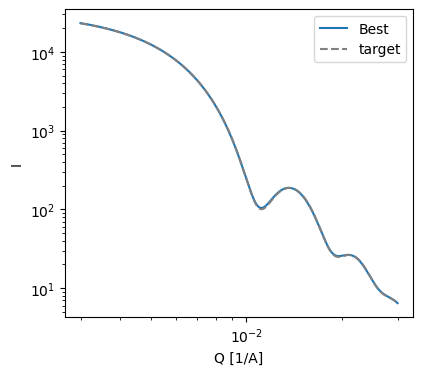

In [151]:
fig, ax = plt.subplots(figsize = (4.5, 4))
ax.loglog(10**q_grid, 10**I_optim0, label = 'Best')
ax.loglog(10**q_grid, 10**target_I, ls = '--', color = 'gray', label = 'target')
ax.set_xlabel('Q [1/A]')
ax.set_ylabel('I')
ax.legend()
plt.savefig('Newcampaign_Optimrep0best.png', dpi = 300)

In [152]:
optimrep0[optim_uid]

{'teos_vol_frac': tensor(0.0081),
 'ammonia_vol_frac': tensor(0.0313),
 'water_vol_frac': tensor(0.0050),
 'scattering_I': array([2.32431030e+04, 2.32068007e+04, 2.31703811e+04, ...,
        6.56221493e+00, 6.50861672e+00, 6.45435962e+00]),
 'real_sampled_point': [0.008019118421493287,
  0.0312984257964179,
  0.005168037131276689],
 'diameter': 80.0654780400806,
 'pdi': 0.10207482627839737,
 'distance': tensor(0.0169, dtype=torch.float64),
 'ap_distance_reporting': tensor(0.0169, dtype=torch.float64),
 'I_scaled': array([4.36649396, 4.36581513, 4.36513303, ..., 0.8172503 , 0.81368855,
        0.81005301])}

## re-run distance calculation for sobol baseline

In [ ]:
new_results = []

for i in range(3):
    replicate_results = []
    with open(f'SobolBaseline_replicate_{i}.pkl', 'rb') as f:
        campaign_data = pickle.load(f)

    for uid, entry in campaign_data.items():
        sample_results = {}
        I = entry['I_scaled']
        amplitude, phase, output = torch_apdist(torch.from_numpy(q_grid_scaled), # all the inputs should be torch.Tensor
                                        torch.from_numpy(target_I), 
                                        torch.from_numpy(I), 
                                        **torch_optim_kwargs
                                        )
        report_distance = 0.9*amplitude + 0.1*phase
        sample_results['uuid'] = uid
        sample_results['amplitude'] = amplitude
        sample_results['phase'] = phase
        sample_results['ap_report'] = report_distance
        replicate_results.append(sample_results)
    new_results.append(replicate_results)
    with open('recalculate_sobolbaseline.pkl', 'wb') as f:
        pickle.d
        

In [10]:
with open('recalculate_sobolbaseline0.pkl', 'rb') as f:
    sobol_0 = pickle.load(f)

In [11]:
sobol_0

[{'uuid': 'ea8d5054-8e19-4239-be48-1b2584270829',
  'amplitude': tensor(0.6594, dtype=torch.float64),
  'phase': tensor(0.5140),
  'ap_report': tensor(0.6449, dtype=torch.float64)},
 {'uuid': '237ba06b-980d-4dce-8efe-e1009d28fd22',
  'amplitude': tensor(1.3734, dtype=torch.float64),
  'phase': tensor(0.5821),
  'ap_report': tensor(1.2942, dtype=torch.float64)},
 {'uuid': '51c0203a-9964-4bb5-a543-3a0f84ae4965',
  'amplitude': tensor(0.6601, dtype=torch.float64),
  'phase': tensor(0.5126),
  'ap_report': tensor(0.6454, dtype=torch.float64)},
 {'uuid': '4cd015aa-da53-451d-96e4-26580d24da63',
  'amplitude': tensor(0.5048, dtype=torch.float64),
  'phase': tensor(0.3429),
  'ap_report': tensor(0.4886, dtype=torch.float64)},
 {'uuid': 'ef1baee7-84d0-42c3-bdae-ffb6ce15c141',
  'amplitude': tensor(0.6615, dtype=torch.float64),
  'phase': tensor(0.5046),
  'ap_report': tensor(0.6458, dtype=torch.float64)},
 {'uuid': '4eec1754-648e-4693-8d5c-da5fc99226b8',
  'amplitude': tensor(0.6594, dtype=torc

In [20]:

best_uuids = []
best_apdist = None
for entry in sobol_0:
    if best_apdist is None:
        best_apdist = [entry['ap_report']]
        best_uuids.append(entry['uuid'])
    else:
        if entry['ap_report'] < best_apdist[-1]:
            best_apdist.append(entry['ap_report'])
            best_uuids.append(entry['uuid'])
        else:
            best_apdist.append(best_apdist[-1])

In [21]:
best_apdist

[tensor(0.6449, dtype=torch.float64),
 tensor(0.6449, dtype=torch.float64),
 tensor(0.6449, dtype=torch.float64),
 tensor(0.4886, dtype=torch.float64),
 tensor(0.4886, dtype=torch.float64),
 tensor(0.4886, dtype=torch.float64),
 tensor(0.4886, dtype=torch.float64),
 tensor(0.4886, dtype=torch.float64),
 tensor(0.4886, dtype=torch.float64),
 tensor(0.4886, dtype=torch.float64),
 tensor(0.4886, dtype=torch.float64),
 tensor(0.4886, dtype=torch.float64),
 tensor(0.4886, dtype=torch.float64),
 tensor(0.4886, dtype=torch.float64),
 tensor(0.4886, dtype=torch.float64),
 tensor(0.4886, dtype=torch.float64),
 tensor(0.4886, dtype=torch.float64),
 tensor(0.4886, dtype=torch.float64),
 tensor(0.4886, dtype=torch.float64),
 tensor(0.4886, dtype=torch.float64),
 tensor(0.4886, dtype=torch.float64),
 tensor(0.4886, dtype=torch.float64),
 tensor(0.4886, dtype=torch.float64),
 tensor(0.4886, dtype=torch.float64),
 tensor(0.4886, dtype=torch.float64),
 tensor(0.4886, dtype=torch.float64),
 tensor(0.48

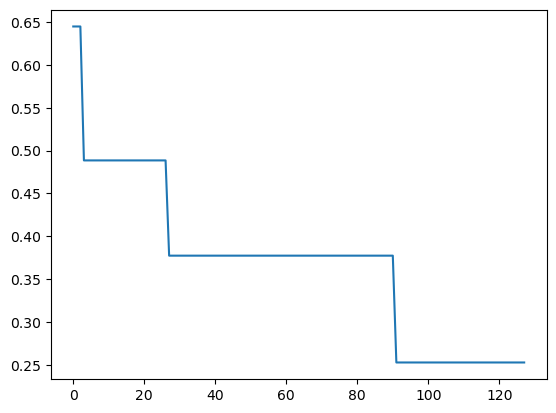

In [22]:
plt.plot(best_apdist)